In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
import pathlib


data_dir = pathlib.Path("brain_tumor_dataset")

In [10]:
os.getcwd()

'C:\\Users\\kaush\\Downloads'

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

245


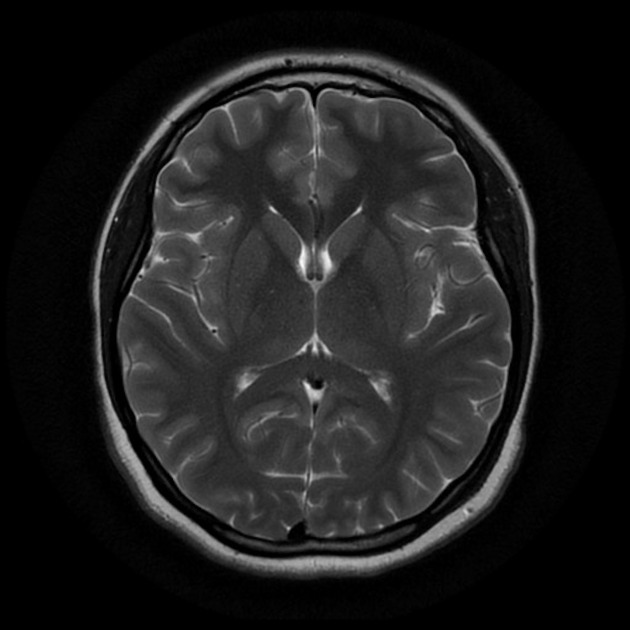

In [12]:
no = list(data_dir.glob('no/*'))
PIL.Image.open(str(no[0]))

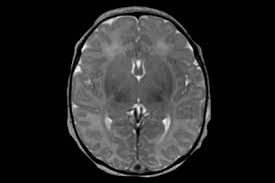

In [13]:
PIL.Image.open(str(no[3]))

In [14]:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 203 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


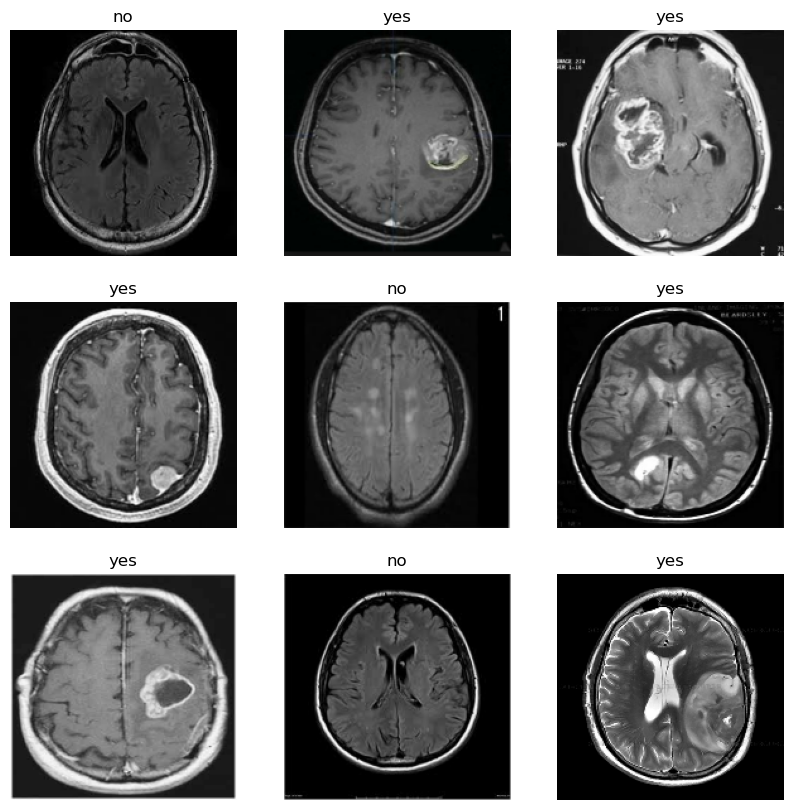

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
normalization_layer = layers.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06666667 0.9839869


In [23]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [28]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
7/7 [==============================] - 2s 304ms/step - loss: 0.0779 - accuracy: 0.9803 - val_loss: 0.9126 - val_accuracy: 0.7800
Epoch 2/25
7/7 [==============================] - 2s 261ms/step - loss: 0.0710 - accuracy: 0.9704 - val_loss: 0.6528 - val_accuracy: 0.8200
Epoch 3/25
7/7 [==============================] - 2s 284ms/step - loss: 0.0411 - accuracy: 0.9901 - val_loss: 0.7549 - val_accuracy: 0.8400
Epoch 4/25
7/7 [==============================] - 2s 223ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.7728 - val_accuracy: 0.7600
Epoch 5/25
7/7 [==============================] - 2s 227ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.8588 - val_accuracy: 0.7600
Epoch 6/25
7/7 [==============================] - 2s 233ms/step - loss: 0.0276 - accuracy: 0.9901 - val_loss: 1.3196 - val_accuracy: 0.8200
Epoch 7/25
7/7 [==============================] - 2s 256ms/step - loss: 0.0734 - accuracy: 0.9557 - val_loss: 0.7960 - val_accuracy: 0.7400
Epoch 8/25
7/7 [====

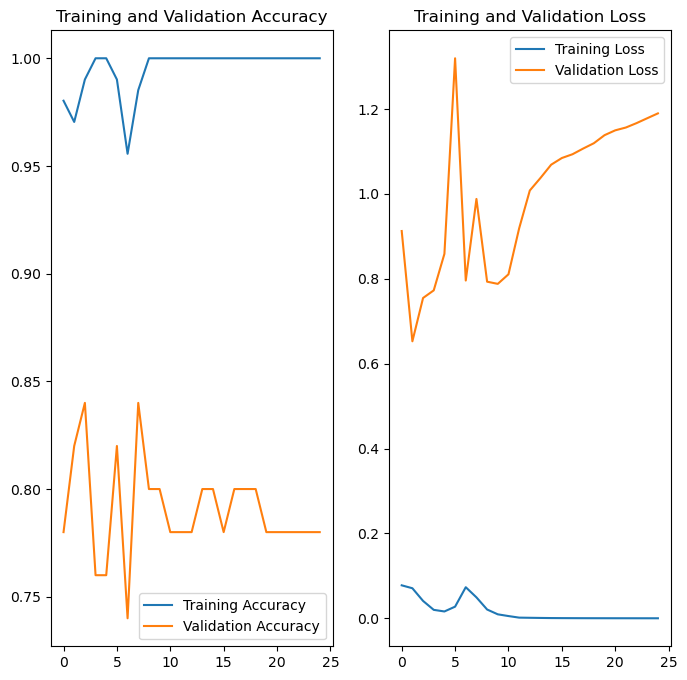

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

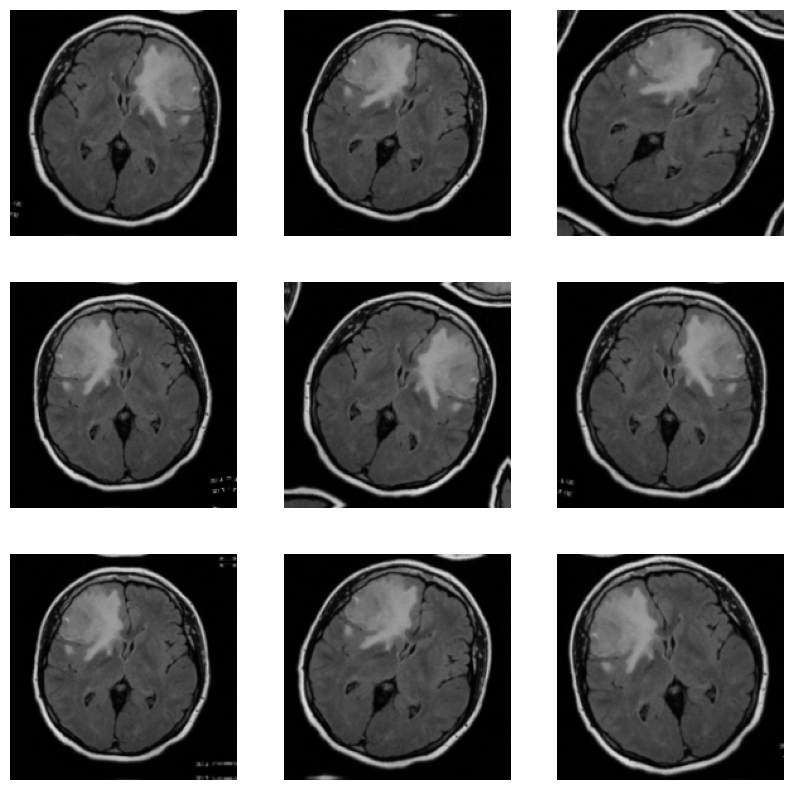

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [32]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [44]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 3s 424ms/step - loss: 0.1171 - accuracy: 0.9458 - val_loss: 0.8338 - val_accuracy: 0.9000
Epoch 2/10
7/7 [==============================] - 3s 429ms/step - loss: 0.0484 - accuracy: 0.9901 - val_loss: 0.9237 - val_accuracy: 0.9000
Epoch 3/10
7/7 [==============================] - 3s 365ms/step - loss: 0.0711 - accuracy: 0.9803 - val_loss: 0.8458 - val_accuracy: 0.8800
Epoch 4/10
7/7 [==============================] - 2s 335ms/step - loss: 0.0688 - accuracy: 0.9754 - val_loss: 0.8167 - val_accuracy: 0.9000
Epoch 5/10
7/7 [==============================] - 2s 360ms/step - loss: 0.0745 - accuracy: 0.9704 - val_loss: 0.8366 - val_accuracy: 0.8600
Epoch 6/10
7/7 [==============================] - 2s 367ms/step - loss: 0.0661 - accuracy: 0.9803 - val_loss: 0.9828 - val_accuracy: 0.8600
Epoch 7/10
7/7 [==============================] - 2s 344ms/step - loss: 0.1130 - accuracy: 0.9655 - val_loss: 0.7582 - val_accuracy: 0.8800
Epoch 8/10
7/7 [====

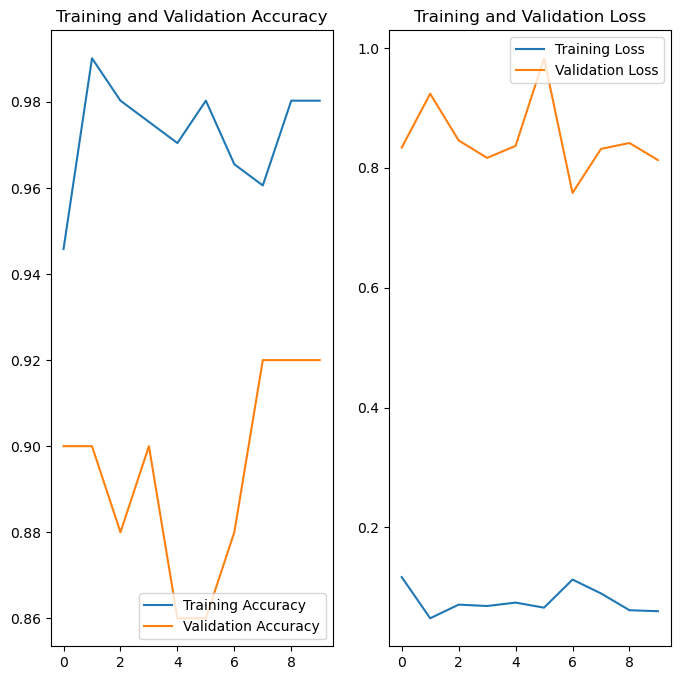

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
img = tf.keras.utils.load_img("C:/Users/kaush/OneDrive/Pictures/bt2.png", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 51ms/step
This image most likely belongs to yes with a 91.51 percent confidence.
